In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from carps.analysis.process_data import get_interpolated_performance_df, load_logs


def print_overview(df_trials: pd.DataFrame) -> None:
    print(df_trials.columns)
    print(df_trials["optimizer_id"].unique())
    print(df_trials["benchmark_id"].unique())
    print(df_trials["problem_id"].unique())
    print(df_trials["scenario"].unique())
    print("Number of seeds", df_trials["seed"].nunique())


rundir = "../runs"

df, df_cfg = load_logs(rundir=rundir)
print_overview(df)
perf = get_interpolated_performance_df(df)
perf_time = get_interpolated_performance_df(df, x_column="time_norm")


[09:22:25] INFO     Load logs from `../runs/logs.csv` and associated configs from               ]8;id=905220;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=47312;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#156\156]8;;\
                    ../runs/logs_cfg.csv. Preprocess logs.                                                         

/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py:162: DtypeWarning: Columns (7,9,21,26,27,28,31,32,33,34,35,41,42,43,46,47,48,49,52,54,55,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(logs_fn)


[09:22:43] INFO     Processing raw logs. Normalize n_trials and costs. Calculate trajectory      ]8;id=251756;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=242652;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#66\66]8;;\
                    (incumbent cost).                                                                              

Index(['n_trials', 'n_function_calls', 'trial_info__config',
       'trial_info__instance', 'trial_info__seed', 'trial_info__budget',
       'trial_info__normalized_budget', 'trial_info__name',
       'trial_info__checkpoint', 'trial_value__cost', 'trial_value__time',
       'trial_value__virtual_time', 'trial_value__status',
       'trial_value__starttime', 'trial_value__endtime', 'seed',
       'benchmark_id', 'problem_id', 'optimizer_id', 'problem.model_id',
       'problem.dataset_id', 'problem.surrogates_dir', 'task.n_trials',
       'task.time_budget', 'task.n_workers', 'task.n_objectives',
       'task.objectives', 'task.is_multifidelity', 'task.fidelity_type',
       'task.min_budget', 'task.max_budget', 'task.has_constraints',
       'task.domain', 'task.objective_function_approximation',
       'task.has_virtual_time', 'task.deterministic', 'task.dimensions',
       'task.search_space_n_categoricals', 'task.search_space_n_ordinals',
       'task.search_space_n_integers', 'tas

[09:24:38] INFO     Create dataframe for neat plotting by aligning x-axis / interpolating       ]8;id=539115;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=759779;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#126\126]8;;\
                    budget.                                                                                        

[09:24:48] INFO     Create dataframe for neat plotting by aligning x-axis / interpolating       ]8;id=333009;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=842432;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#126\126]8;;\
                    budget.                                                                                        

--------------------------------------------------
blackbox


[09:25:03] INFO     Lost following experiments: optimizer_id                             HEBO    ]8;id=234170;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py\run_autorank.py]8;;\:]8;id=509721;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py#38\38]8;;\
                    Optuna  RandomSearch  \                                                                        
                    problem_id                                                                                     
                    hpob/all/124/41                           NaN     NaN           NaN                            
                    hpobench/bb/surr/ParamNet/Adult      0.147372     NaN      0.148512                            
                    hpobench/bb/surr/ParamNet/Higgs      0.280784     NaN      0.282628                            
                    hpobench/bb/surr/ParamNet/Letter     0.037133     NaN      0.045086                            
                    hpobench/bb/surr/ParamNet/Mnist      0.016734     NaN      0.016279                            
                    hpobench/bb/surr/ParamNet/Optdigits  0.016750     NaN      0.017812                            
                    hpobench/bb/surr/ParamNet/Poker      0.001163     NaN      0.001761                            
                    hpobench/bb/surr/SVM/default         0.103146     NaN      0.016025                            
                    yahpo/so/nb301/CIFAR10/None               NaN     NaN    -94.121498                            
                    yahpo/so/rbv2_ranger/16/None        -0.933827     NaN     -0.960873                            
                    yahpo/so/rbv2_ranger/42/None        -0.752744     NaN     -0.986910                            
                    yahpo/so/rbv2_super/1053/None             NaN     NaN     -0.886232                            
                    yahpo/so/rbv2_super/1063/None             NaN     NaN     -0.915074                            
                    yahpo/so/rbv2_super/1457/None             NaN     NaN     -0.802621                            
                    yahpo/so/rbv2_super/1468/None             NaN     NaN     -0.973820                            
                    yahpo/so/rbv2_super/1479/None             NaN     NaN     -0.987557                            
                    yahpo/so/rbv2_super/15/None               NaN     NaN     -0.984062                            
                    yahpo/so/rbv2_xgboost/12/None       -0.772316     NaN     -0.982029                            
                    yahpo/so/rbv2_xgboost/1501/None     -0.445844     NaN     -0.922245                            
                    yahpo/so/rbv2_xgboost/16/None       -0.120207     NaN     -0.972923                            
                    yahpo/so/rbv2_xgboost/40499/None    -0.813110     NaN     -0.997573                            
                                                                                                                   
                    optimizer_id                         SMAC3-1.4-BlackBoxFacade  \                               
                    problem_id                                                                                     
                    hpob/all/124/41                                           NaN                                  
                    hpobench/bb/surr/ParamNet/Adult                      0.147286                                  
                    hpobench/bb/surr/ParamNet/Higgs                      0.280454                                  
                    hpobench/bb/surr/ParamNet/Letter                     0.037040                                  
                    hpobench/bb/surr/ParamNet/Mnist                      0.016029                                  
                    h

Rejecting null hypothesis that data is normal for column HEBO (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column Optuna (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column RandomSearch (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SMAC3-1.4-BlackBoxFacade (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SMAC3-BlackBoxFacade (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SMAC3-BlackBoxFacade-fix (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SyneTune-BO (p=0.000000<0.007143)
Using Levene's test for homoscedacity of non-normal data.
Fail to reject null hypothesis that all variances are equal (p=0.913111>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the dista

/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versi

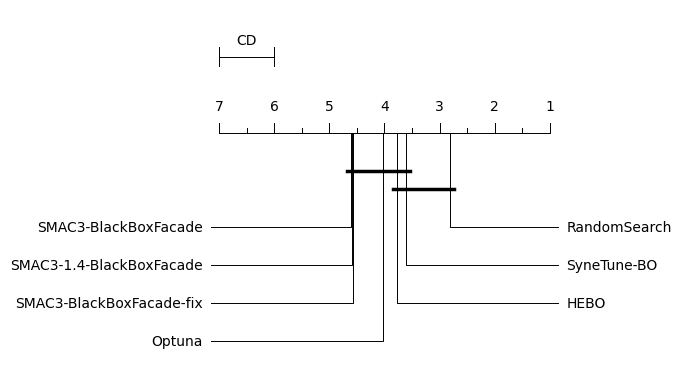

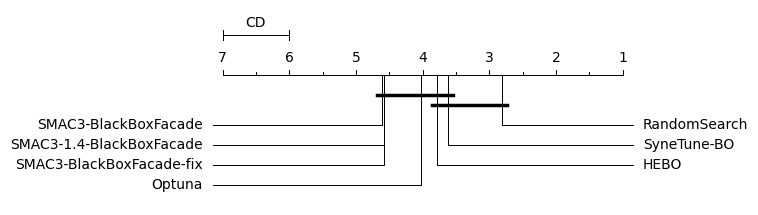

--------------------------------------------------
multi-fidelity


[09:25:09] INFO     Lost following experiments: optimizer_id                                     ]8;id=449767;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py\run_autorank.py]8;;\:]8;id=935531;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py#38\38]8;;\
                    DEHB  RandomSearch  \                                                                          
                    problem_id                                                                                     
                    hpobench/mf/real/ml/lr/10101/subsample              0.204036      0.211211                     
                    hpobench/mf/real/ml/lr/12/subsample                 0.004545      0.004545                     
                    hpobench/mf/real/ml/lr/146212/subsample             0.044775      0.049077                     
                    hpobench/mf/real/ml/lr/146606/subsample             0.356602      0.357580                     
                    hpobench/mf/real/ml/lr/146818/subsample             0.123415      0.124878                     
                    ...                                                      ...           ...                     
                    yahpo/multifidelity/so/trainsize/rbv2_super/15/... -0.982791     -0.982689                     
                    yahpo/multifidelity/so/trainsize/rbv2_xgboost/1... -0.985130     -0.983784                     
                    yahpo/multifidelity/so/trainsize/rbv2_xgboost/1... -0.937020     -0.931755                     
                    yahpo/multifidelity/so/trainsize/rbv2_xgboost/1... -0.977955     -0.972702                     
                    yahpo/multifidelity/so/trainsize/rbv2_xgboost/4... -0.998921     -0.997119                     
                                                                                                                   
                    optimizer_id                                                                                   
                    SMAC3-1.4-MultiFidelityFacade  \                                                               
                    problem_id                                                                                     
                    hpobench/mf/real/ml/lr/10101/subsample                                                         
                    0.208520                                                                                       
                    hpobench/mf/real/ml/lr/12/subsample                                                            
                    0.005051                                                                                       
                    hpobench/mf/real/ml/lr/146212/subsample                                                        
                    0.046082                                                                                       
                    hpobench/mf/real/ml/lr/146606/subsample                                                        
                    0.357374                                                                                       
                    hpobench/mf/real/ml/lr/146818/subsample                                                        
                    0.130244                                                                                       
                    ...                                                                                            
                    ...                                                                                            
                    yahpo/multifidelity/so/trainsize/rbv2_super/15/...                                             
                    -0.985129                                                                                      
                    y

Rejecting null hypothesis that data is normal for column DEHB (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column RandomSearch (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SMAC3-1.4-MultiFidelityFacade (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SMAC3-Hyperband (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SMAC3-MultiFidelityFacade (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SyneTune-ASHA (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SyneTune-DEHB (p=0.000000<0.007143)
Using Levene's test for homoscedacity of non-normal data.
Fail to reject null hypothesis that all variances are equal (p=0.999852>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if

/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versi

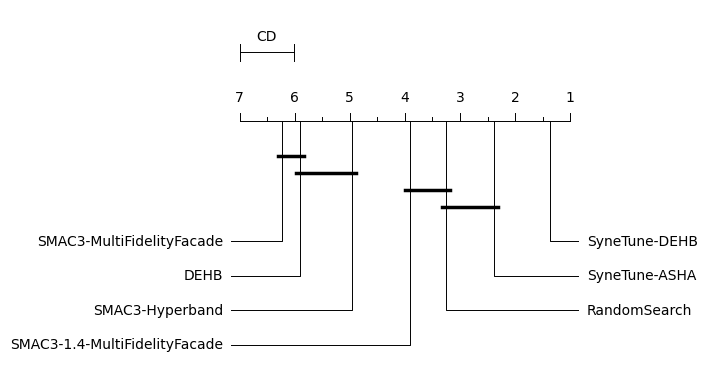

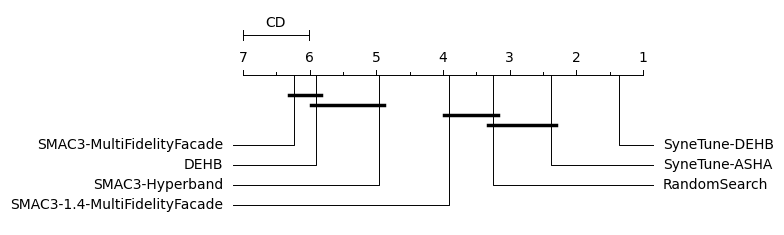

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats, create_report, latex_table
from carps.analysis.run_autorank import calc_critical_difference

scenarios = ["blackbox", "multi-fidelity"]
for scenario in scenarios:
    print("-"*50)
    print(scenario)
    result = calc_critical_difference(df[df["scenario"]==scenario], identifier=scenario)
    plot_stats(result)
    plt.show()

In [3]:

# fig, axes = plot_interval_estimates(performance_data=perf, load_from_pickle=False, figure_filename="figures/plot_interval_estimates.pdf")

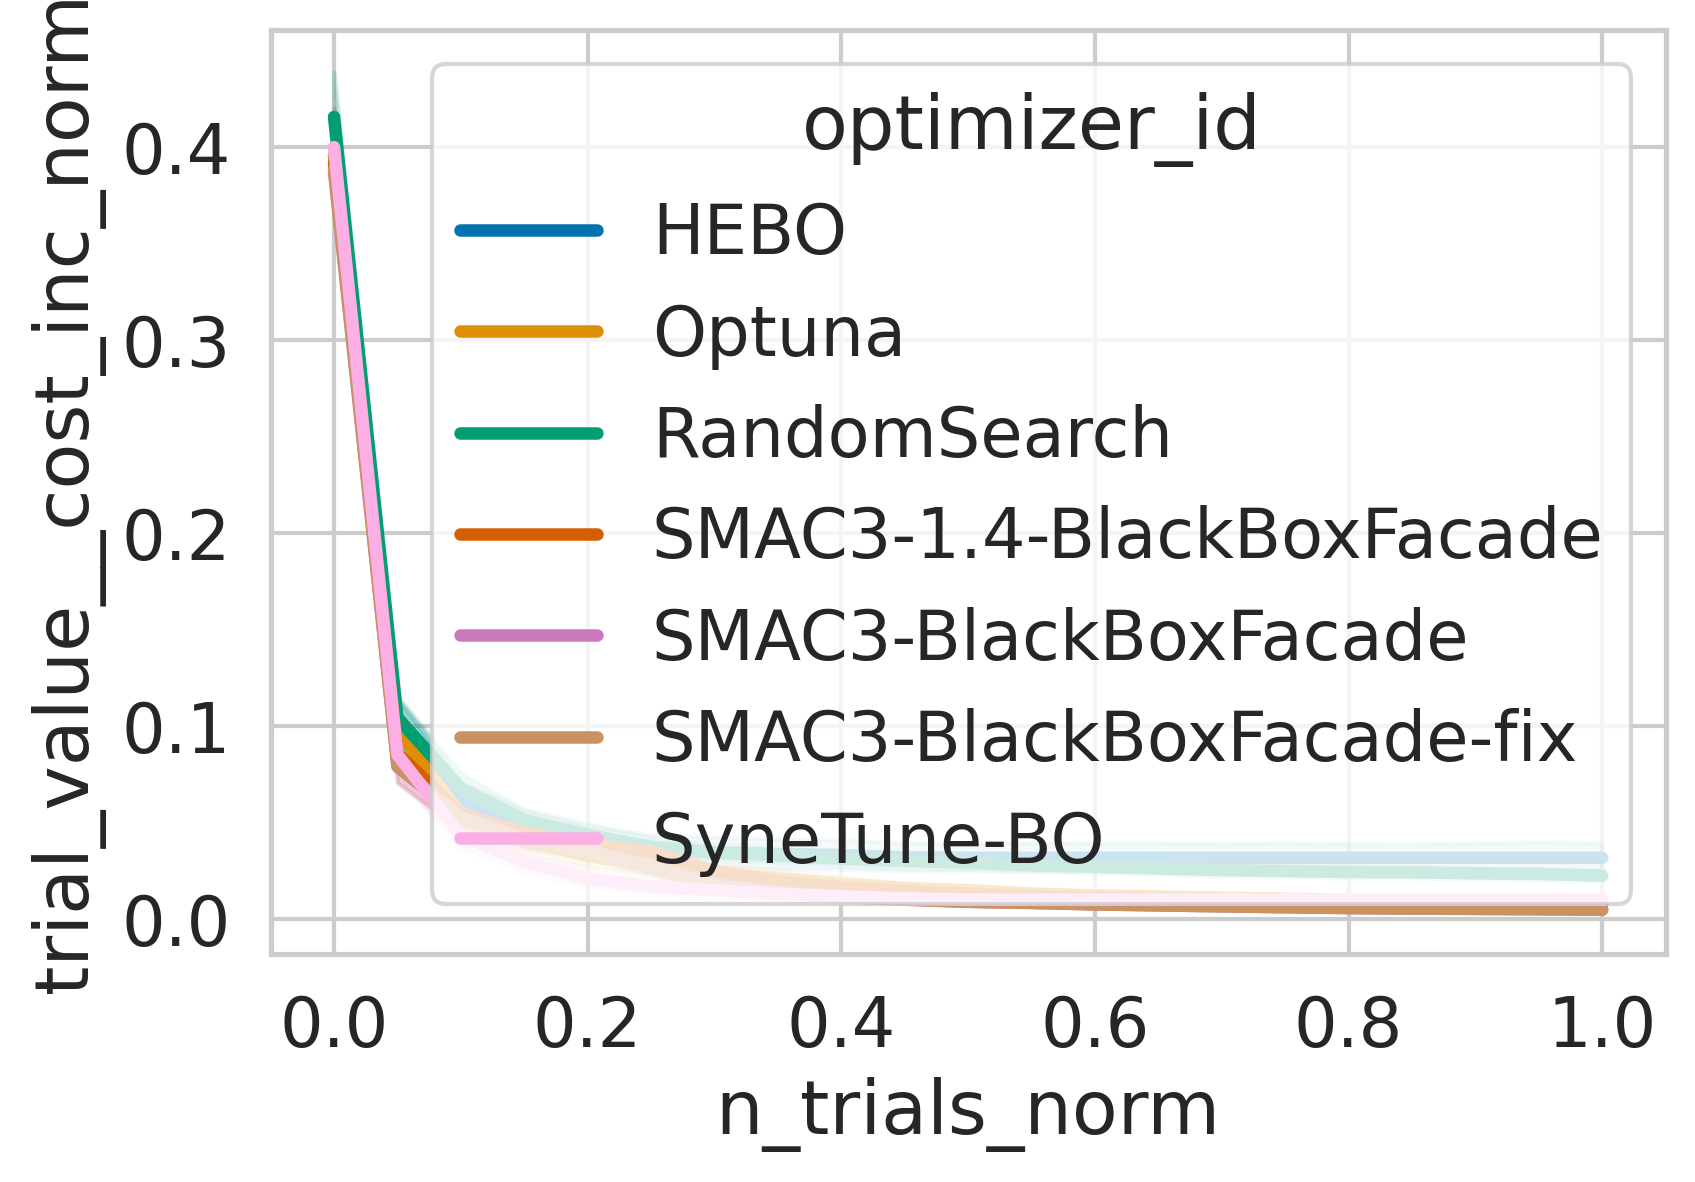

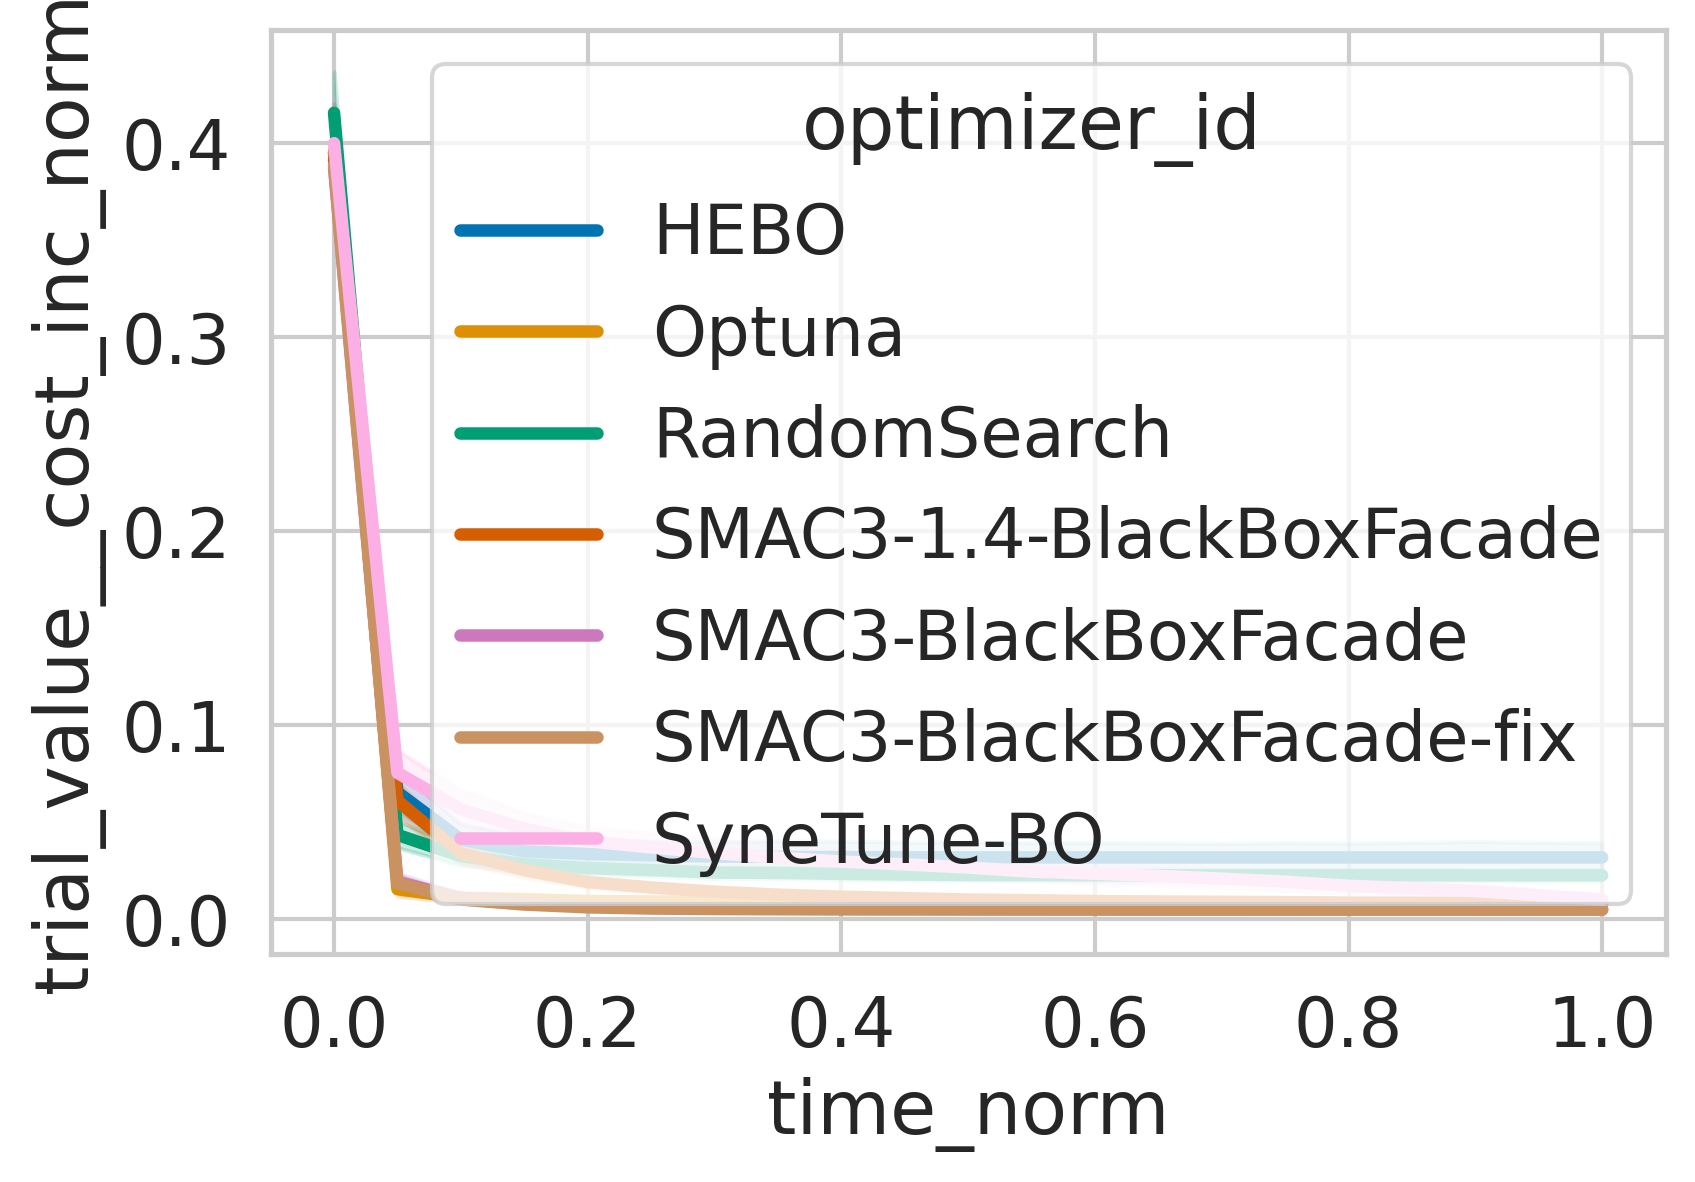

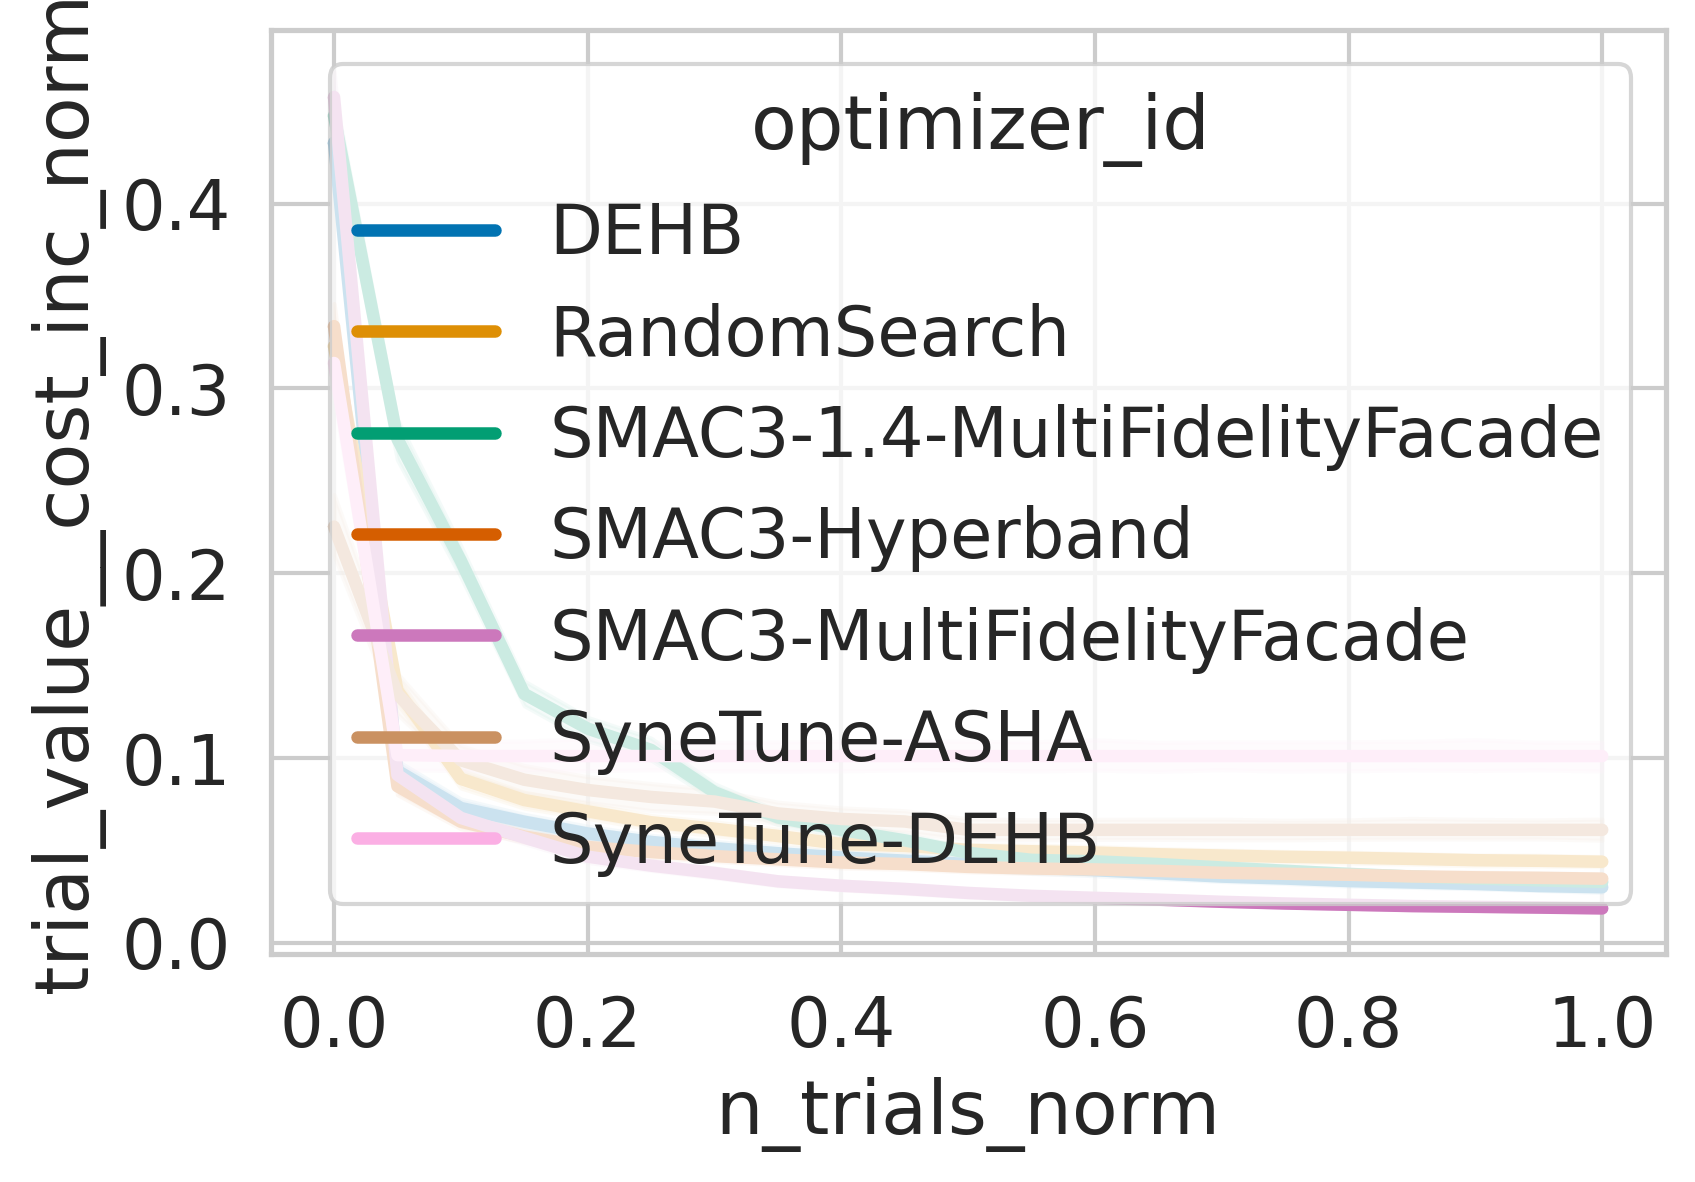

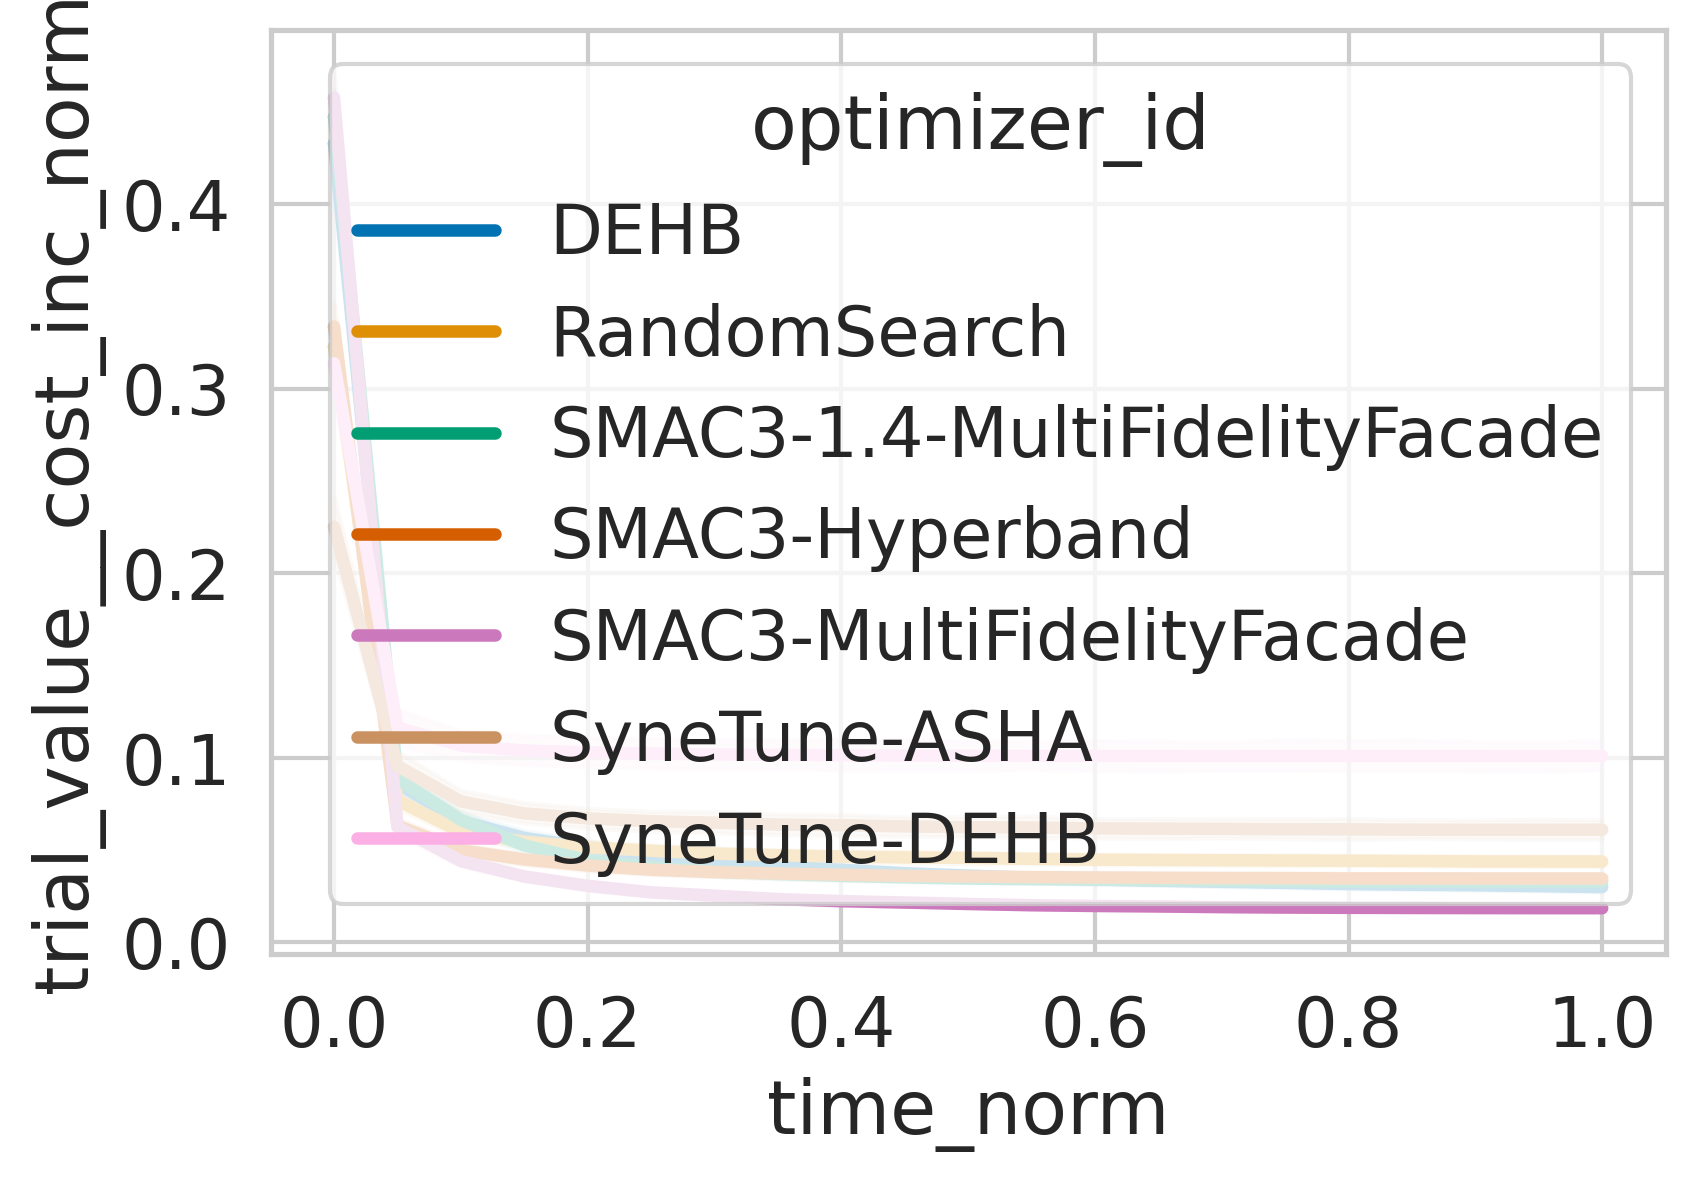

In [4]:
from carps.analysis.performance_over_time import plot_performance_over_time
lineplot_kwargs = dict(linewidth=3)
scenarios = ["blackbox", "multi-fidelity"]
for scenario in scenarios:
    fig, ax = plot_performance_over_time(
        df=perf[perf["scenario"]==scenario], 
        x="n_trials_norm", 
        y="trial_value__cost_inc_norm", 
        hue="optimizer_id", 
        figure_filename=f"figures/performance_over_time_{scenario}_trials.pdf", 
        figsize=(6,4), 
        **lineplot_kwargs
    )
    fig, ax = plot_performance_over_time(
        df=perf_time[perf_time["scenario"]==scenario], 
        x="time_norm", 
        y="trial_value__cost_inc_norm", 
        hue="optimizer_id", 
        figure_filename=f"figures/performance_over_time_{scenario}_elapsed.pdf", 
        figsize=(6,4), 
        **lineplot_kwargs
    )

In [5]:
# Plot per benchmark
from carps.analysis.utils import get_color_palette, savefig
from carps.analysis.performance_over_time import plot_performance_over_time

palette = get_color_palette(perf)
lineplot_kwargs = dict(linewidth=3)

scenarios = ["blackbox", "multi-fidelity"]

for scenario in scenarios:
    _perf = perf[perf["scenario"]==scenario]
    _perf_time = perf_time[perf_time["scenario"]==scenario]
    # Iterations
    for gid, gdf in _perf.groupby(by="benchmark_id"):    
        figure_filename = f"figures/performance_over_time_trials_{scenario}_{gid}.pdf"
        fig, ax = plot_performance_over_time(df=gdf, x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename=figure_filename, figsize=(6,4), **lineplot_kwargs)
        ax.set_title(gid)
        savefig(fig, figure_filename)
        plt.show()

    # Elapsed time
    for gid, gdf in _perf_time.groupby(by="benchmark_id"):    
        figure_filename = f"figures/performance_over_time_elapsed_{scenario}_{gid}.pdf"
        fig, ax = plot_performance_over_time(df=gdf, x="time_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename=figure_filename, figsize=(6,4), **lineplot_kwargs)
        ax.set_title(gid)
        savefig(fig, figure_filename)
        plt.show()

IndexError: list index out of range

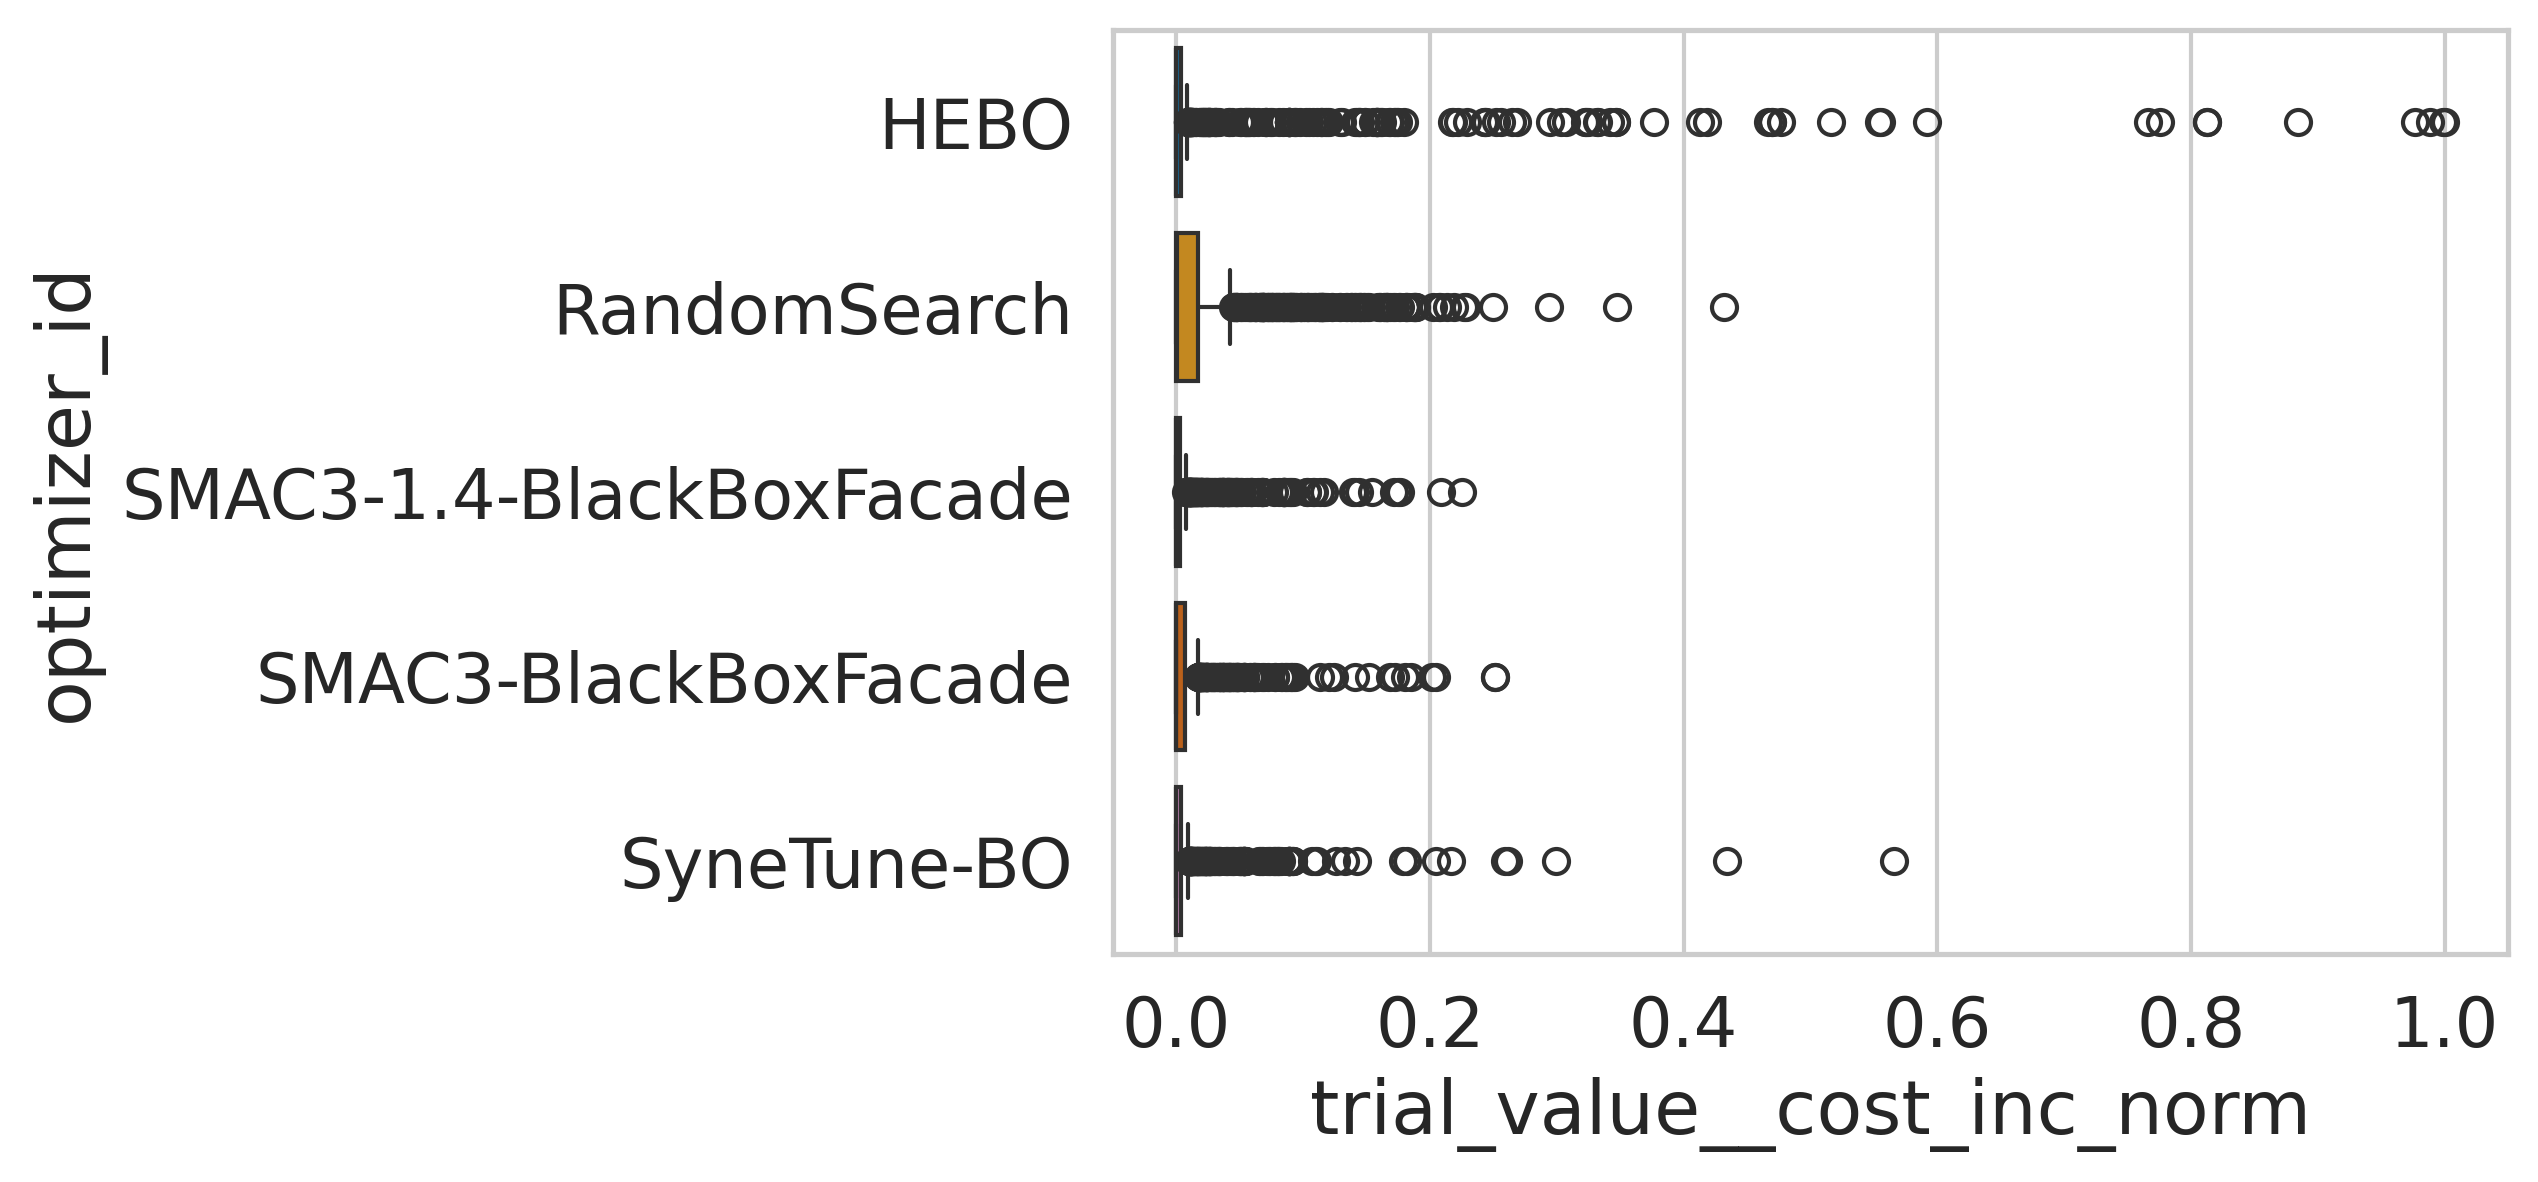

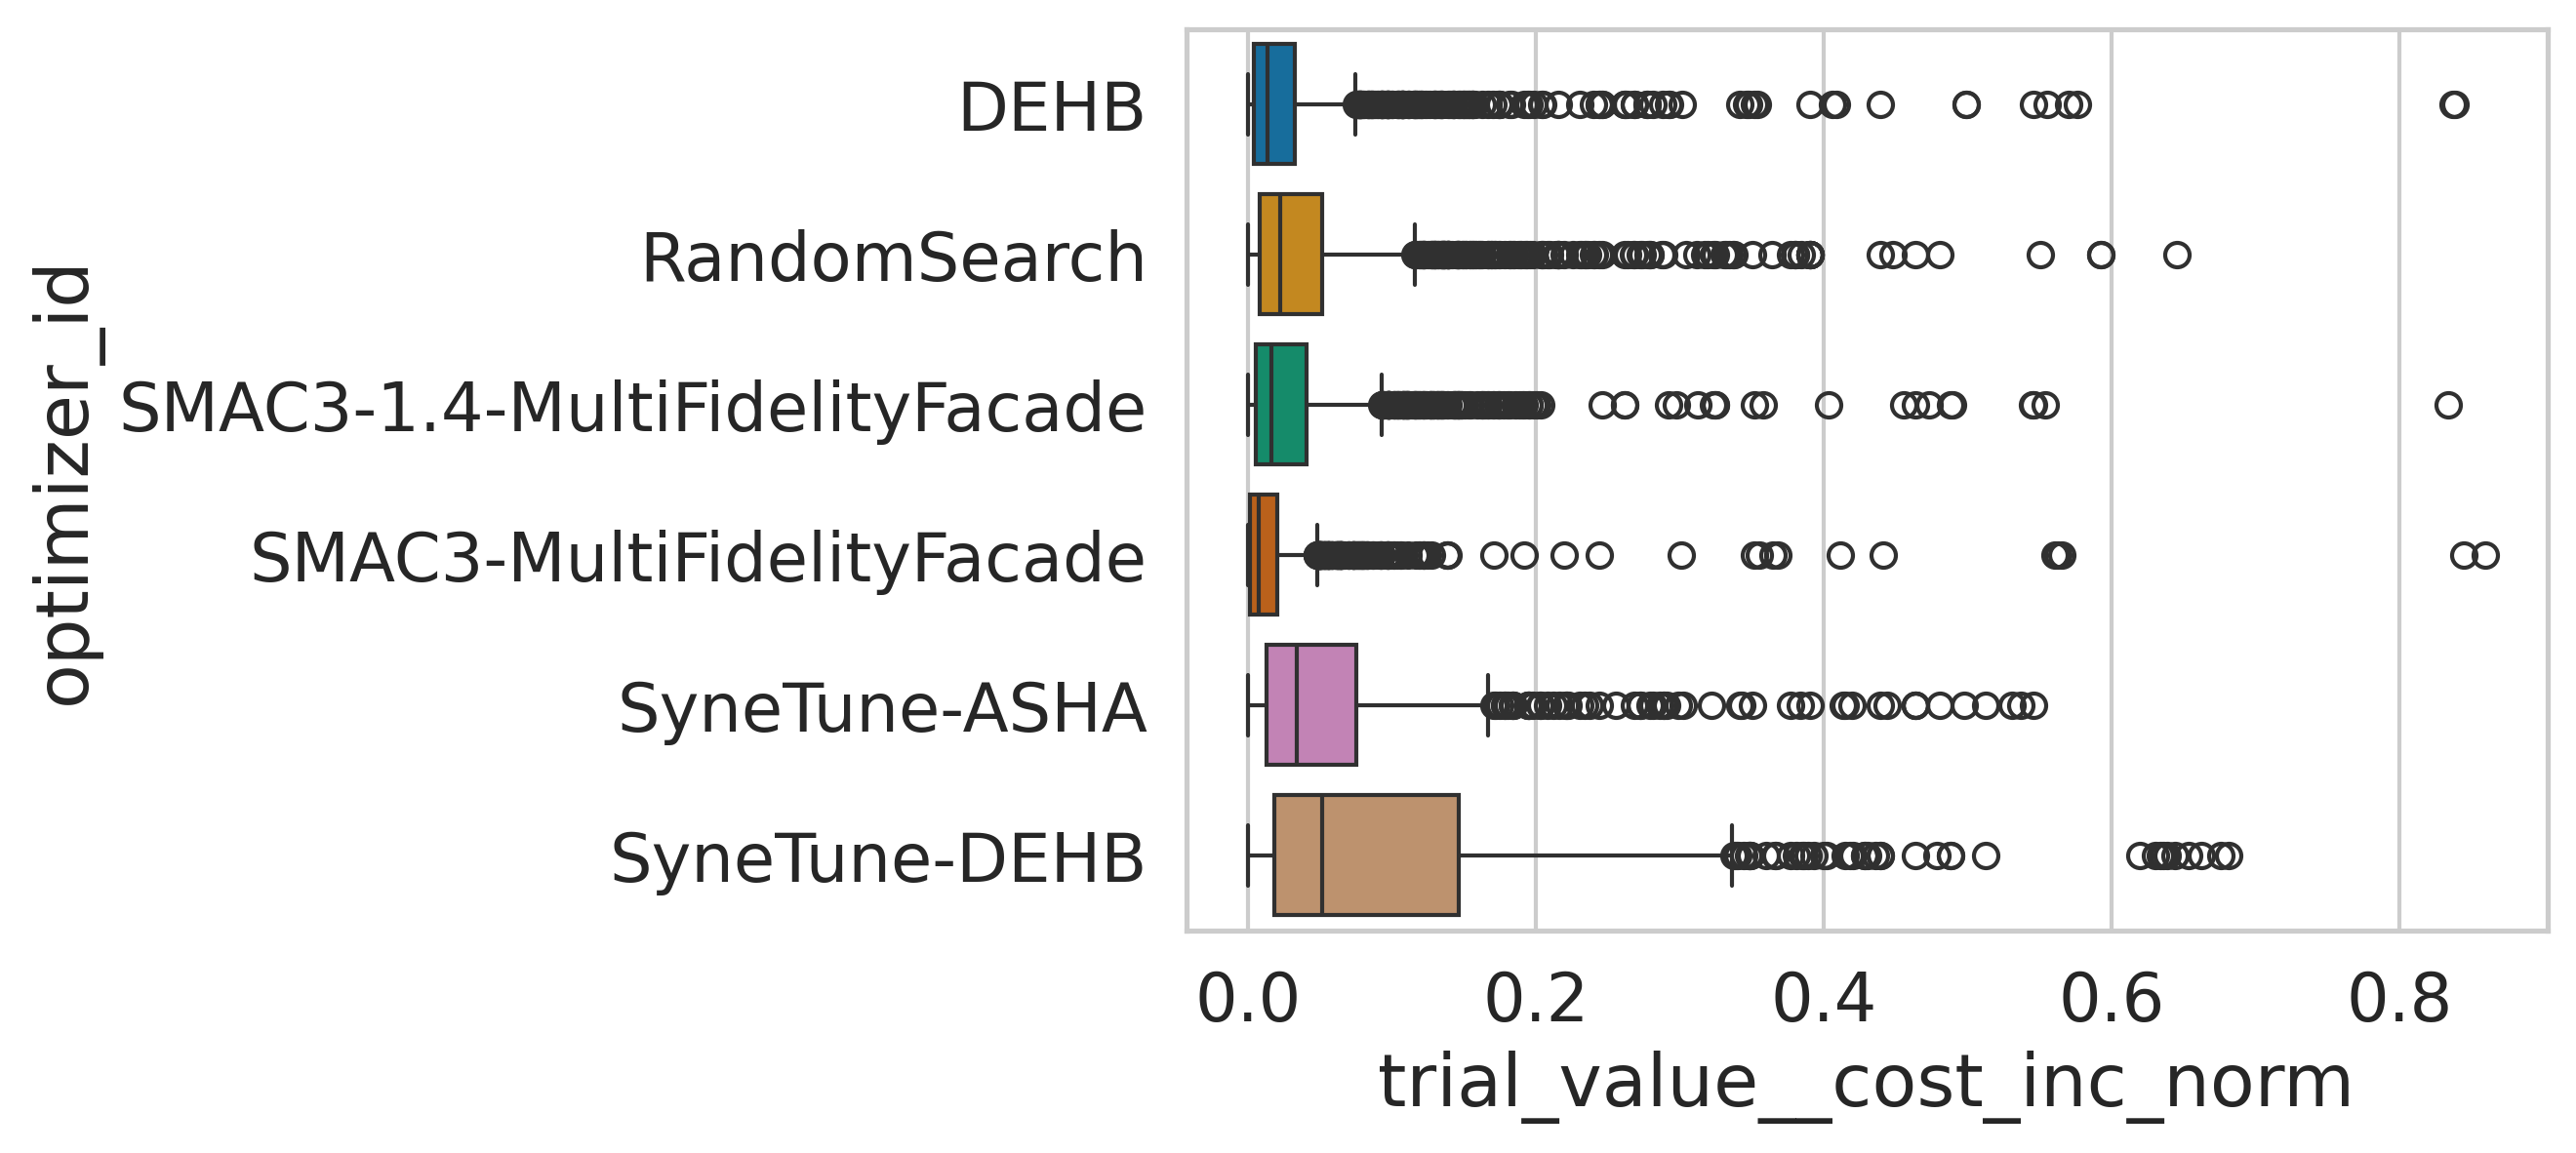

In [ ]:
from carps.analysis.final_performance import plot_final_performance_boxplot

boxplot_kwargs = dict()

scenarios = ["blackbox", "multi-fidelity"]
for scenario in scenarios:
    fig, ax = plot_final_performance_boxplot(
        df=perf[perf["scenario"]==scenario], 
        x="trial_value__cost_inc_norm", y="optimizer_id", hue="optimizer_id", figure_filename=f"figures/final_performance_boxplot_{scenario}.pdf", figsize=(6,4), **boxplot_kwargs)

In [ ]:
max_val = df["n_trials_norm"].max()
error = df.groupby(by=["benchmark_id", "problem_id", "optimizer_id", "seed"])["n_trials_norm"].apply(lambda x: not np.isclose(x.max(), max_val))
error = error[error]
for i in error.index:
    print(i)

('BBOB', 'noiseless/5/1/0', 'HEBO', 1)
('BBOB', 'noiseless/5/1/0', 'HEBO', 2)
('BBOB', 'noiseless/5/1/0', 'HEBO', 3)
('BBOB', 'noiseless/5/1/0', 'HEBO', 4)
('BBOB', 'noiseless/5/1/0', 'HEBO', 5)
('BBOB', 'noiseless/5/1/0', 'HEBO', 6)
('BBOB', 'noiseless/5/1/0', 'HEBO', 7)
('BBOB', 'noiseless/5/1/0', 'HEBO', 8)
('BBOB', 'noiseless/5/1/0', 'HEBO', 9)
('BBOB', 'noiseless/5/1/0', 'HEBO', 10)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 1)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 2)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 3)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 4)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 5)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 6)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 7)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 8)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 9)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 10)
('BBOB', 'noiseless/5/10/0', 'HEBO', 1)
('BBOB', 'noiseless/5/10/0', 'HEBO', 2)
('BBOB', 'noiseless/5/10/0', 'HEBO', 3)
('BBOB', 'noiseless/5/10/0',